In [1]:
import datetime as dt
import glob
import os
import pickle
import re
import string
import sys
import time
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import (
    stopwords,
    wordnet,
)
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

nltk.download("wordnet")
from pathlib import Path

from nltk.stem import PorterStemmer
from scipy.stats.mstats import winsorize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
)

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('data/original_data.csv')

In [3]:
# Step 2: Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

# Step 3: Save the training and testing sets into separate CSV files
train = 'data/train.csv'
test = 'data/test.csv'

train_data.to_csv(train, index=False)
test_data.to_csv(test, index=False)

In [4]:
#!pip freeze > requirements.txt

In [5]:
tqdm.pandas()

In [6]:
raw_train = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')

# Real Estate Investment 
You will receive a CSV file with data from a sample project. For this challenge, our client is a real estate investment firm looking to automate the valuation of properties and generate recommendations based on data about each property.
## The Coding Challenge
Create a machine-learning model that predicts the price range of a property based on the information available. The data set contains 10,000 rows (1 row for each property). After training, you should export your model (with all other components you might need) and deploy it into a function or app. This function will be used to score new data points on demand. We expect that you test your function by running it against the training data we provided.

Aditionally, walk us through your approach to applying NLP to our property dataset, specifically focusing on the description field. How you would preprocess the text and then proceed through feature extraction, integration with other features and model training,
### Goals
1. Implement the code to train and tune your model.
2. Function or app to score new data points.
3. List the most relevant features of your model.
4. Give a short explanation of how you would implement the NLP feature.
## Data
We have 10,000 rows of data about properties. The fields we are using are:
Uid - Property ID
city - City where the property is located
description - Free text description of the property
homeType - Property type
latitude - Latitude of the property’s location
longitude - Longitude of the property’s location
garageSpaces - number of garage spaces
hasSpa - Boolean. True if the property has a spa
yearBuilt - the year when the property was built
numOfPatioAndPorchFeatures - number of porches and patios
lotSizeSqFt - Lot Size in squared feet
avgSchoolRating - average school district rating
MedianStudentsPerTeacher - median students per teacher in the school district
numOfBathrooms - number of bathrooms
numOfBedrooms - number of bedrooms
priceRange - property price range

Please remember, all the data here is publicly available and does not represent data from any of our clients.
## Acceptance Criteria
1. Your code should be readable and easy to run
2. You should hand over the code and all other artifacts you used for the challenge
3. Test your model and calculate accuracy metrics
4. Your explanation should cover all steps to implement NLP feature

---

<center><h1>💻💻 Data Preparation 💻 💻</h1></center>

---

In [7]:
raw_train.sample(3)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
1910,10203,austin,ALL ABOUT LOCATION Hip East Austin Location wi...,Single Family,30.256674,-97.700890,0,False,1947,0,7056.0,3.333333,11,1.0,2,350000-450000
190,8532,austin,"3907 Burr Oak Ln, Austin, TX 78727 is a single...",Single Family,30.427259,-97.712570,0,False,1981,2,9147.0,6.666667,15,2.0,3,350000-450000
8446,14221,austin,Classic central Austin single story home on on...,Single Family,30.325480,-97.771919,1,True,1958,0,14810.4,7.000000,16,2.0,3,650000+


In [8]:
raw_train.dtypes

uid                             int64
city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                           bool
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                float64
numOfBedrooms                   int64
priceRange                     object
dtype: object

In [11]:
ORIGINAL_FEATURES = list(raw_train.columns)

with open('data/ORIGINAL_FEATURES', 'wb') as fp0:
    pickle.dump(ORIGINAL_FEATURES, fp0)

In [12]:
raw_train.isnull().sum().sum(), raw_test.isnull().sum().sum()

(0, 1)

In [13]:
raw_train.shape, raw_test.shape

((9000, 16), (1000, 16))

In [14]:
# datatype converter
from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
)

class DataFrameTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, conversion_dict):
        self.conversion_dict = conversion_dict

    def fit(self, X, y=None):
        return self  # Nothing to fit, so just return self

    def transform(self, X):
        X = X.copy()
        for column, new_type in self.conversion_dict.items():
            X[column] = X[column].astype(new_type)
        return X

In [15]:
CONVERSION_DICT = {
    "city": str,
    "latitude": float,
    "longitude": float,
    "description": str,
    "homeType": str,
    "numOfBathrooms": int,
    "hasSpa": str,
}

TO_CONVERT = list(CONVERSION_DICT)

In [16]:
with open('data/CONVERSION_DICT', 'wb') as fp1:
    pickle.dump(CONVERSION_DICT, fp1)

with open('data/TO_CONVERT', 'wb') as fp2:
    pickle.dump(TO_CONVERT, fp2)

In [17]:
converter = DataFrameTypeConverter(CONVERSION_DICT)

In [18]:
raw_train[TO_CONVERT] = converter.fit_transform(raw_train[TO_CONVERT])
raw_test[TO_CONVERT] = converter.fit_transform(raw_test[TO_CONVERT])

In [19]:
raw_train.dtypes

uid                             int64
city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                         object
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                  int64
numOfBedrooms                   int64
priceRange                     object
dtype: object

In [20]:
VARIABLES_TO_DROP = ['uid']

with open('data/VARIABLES_TO_DROP', 'wb') as fp3:
    pickle.dump(VARIABLES_TO_DROP, fp3)

In [21]:
# we are able to remove the uid feature

raw_train.drop(VARIABLES_TO_DROP, axis=1, inplace=True)
raw_test.drop(VARIABLES_TO_DROP, axis=1, inplace=True)

In [22]:
df_train = raw_train.copy()
df_test = raw_test.copy()

In [23]:
df_train.sample()

,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
1685,austin,2-story home on a cul-de-sac in Western Oaks. ...,Single Family,30.220463,-97.856247,2,False,1994,3,8468.0,6.0,17,3,4,450000-650000


In [24]:
df_train[df_train.duplicated()]

,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange


In [25]:
df_test[df_test.duplicated()]

,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange


In [26]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

## Preprocessing Data

### Categorical features

In [27]:
CATEGORICAL_FEATURES = list(df_train.select_dtypes(include=['category','object', 'bool']).columns)

In [28]:
df_train.dtypes

city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                         object
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                  int64
numOfBedrooms                   int64
priceRange                     object
dtype: object

In [29]:
CATEGORICAL_FEATURES

['city', 'description', 'homeType', 'hasSpa', 'priceRange']

In [30]:
df_train.isnull().sum().sum()

0

In [31]:
CATEGORICAL_FEATURES

['city', 'description', 'homeType', 'hasSpa', 'priceRange']

In [32]:
class ModeImputer:
    def __init__(self, variables=None):
        self.variables = variables
        self.mode_dict = {}

    def fit(self, df):
        for col in self.variables:
            self.mode_dict[col] = df[col].mode()[0]
        return self

    def transform(self, df):
        df = df.copy()
        for col in self.variables:
            df[col].fillna(self.mode_dict[col], inplace=True)
        return df

In [33]:
df_train[CATEGORICAL_FEATURES] = (
    ModeImputer(variables=CATEGORICAL_FEATURES)
    .fit(df_train[CATEGORICAL_FEATURES])
    .transform(df_train[CATEGORICAL_FEATURES])
)
df_test[CATEGORICAL_FEATURES] = (
    ModeImputer(variables=CATEGORICAL_FEATURES)
    .fit(df_test[CATEGORICAL_FEATURES])
    .transform(df_test[CATEGORICAL_FEATURES])
)

In [34]:
df_train[CATEGORICAL_FEATURES].dtypes

city           object
description    object
homeType       object
hasSpa         object
priceRange     object
dtype: object

In [35]:
df_train[CATEGORICAL_FEATURES].nunique().reset_index().sort_values(by=0, ascending=False)

,index,0
1,description,8985
2,homeType,10
0,city,7
4,priceRange,5
3,hasSpa,2


In [36]:
df_train['homeType'].value_counts()

homeType
Single Family            8488
Condo                     300
Townhouse                  99
Multiple Occupancy         53
Residential                23
Apartment                  17
Mobile / Manufactured       9
MultiFamily                 5
Vacant Land                 4
Other                       2
Name: count, dtype: int64

In [37]:
df_test['homeType'].value_counts()

homeType
Single Family            939
Condo                     33
Townhouse                 14
Multiple Occupancy         7
Residential                4
Apartment                  2
Mobile / Manufactured      1
Name: count, dtype: int64

In [38]:
df_train['city'].value_counts()

city
austin              8910
del valle             52
pflugerville          25
driftwood              7
manchaca               3
dripping springs       2
west lake hills        1
Name: count, dtype: int64

In [39]:
df_train['priceRange'].value_counts(normalize=True)

priceRange
250000-350000    0.235889
350000-450000    0.230667
450000-650000    0.228222
650000+          0.181667
0-250000         0.123556
Name: proportion, dtype: float64

Note that for the homeType feature we need to create a frequency dependent feature in order to consider variables with a few of appeareances in the data, e.g., Other, Vacant Land, and so on:

In [40]:
FEATURES_MODIFY = ['homeType', 'city']

with open('data/FEATURES_MODIFY', 'wb') as fp5:
    pickle.dump(FEATURES_MODIFY, fp5)

In [41]:
class DataFrameProcessor:
    def __init__(self, features, quantile_threshold=0.1):
        self.features = features
        self.quantile_threshold = quantile_threshold
        self.feature_quantiles_ = {}
        self.feature_value_counts_ = {}

    def fit(self, X, y=None):

        for feature in self.features:
            value_counts = X[feature].value_counts()
            self.feature_value_counts_[feature] = value_counts
            self.feature_quantiles_[feature] = (
                X[feature].map(value_counts).quantile(self.quantile_threshold)
            )

        return self

    def transform(self, X):
        X = X.copy()  # Make a copy of the input DataFrame to avoid altering original data

        for feature in self.features:
            X[feature + "_count"] = X[feature].map(self.feature_value_counts_[feature])
            quantile_value = self.feature_quantiles_[feature]

            # Apply "OTHER" transformation
            X[feature] = X.apply(
                lambda row: (
                    "OTHER" if X[feature + "_count"][row.name] < quantile_value else row[feature]
                ),
                axis=1,
            )

        return X

In [42]:
dataframe = DataFrameProcessor(features = FEATURES_MODIFY, quantile_threshold=0.1).fit(X=df_train).transform(X=df_train)

In [43]:
dataframe_test = DataFrameProcessor(features = FEATURES_MODIFY, quantile_threshold=0.1).fit(X=df_test).transform(X=df_test)

In [44]:
dataframe['homeType'].value_counts()

homeType
Single Family    8488
OTHER             512
Name: count, dtype: int64

In [45]:
dataframe['city'].value_counts()

city
austin    8910
OTHER       90
Name: count, dtype: int64

In [46]:
dataframe_test['homeType'].value_counts()

homeType
Single Family    939
OTHER             61
Name: count, dtype: int64

In [47]:
dataframe_test.isnull().sum().sum()

0

In [48]:
temp_ht_train = df_train['homeType'].value_counts()
temp_city_train = df_train['city'].value_counts()

temp_ht_test = df_test['homeType'].value_counts()
temp_city_test = df_test['city'].value_counts()

In [49]:
df_train['homeType_count'] = df_train['homeType'].progress_apply(lambda x: temp_ht_train[x])
df_train['city_count'] = df_train['city'].progress_apply(lambda x: temp_city_train[x])

df_test['homeType_count'] = df_test['homeType'].progress_apply(lambda x: temp_ht_test[x])
df_test['city_count'] = df_test['city'].progress_apply(lambda x: temp_city_test[x])

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 168500.08it/s]


In [50]:
df_train[['homeType','homeType_count','city', 'city_count']].sample(3)

,homeType,homeType_count,city,city_count
1619,Single Family,8488,austin,8910
1521,Single Family,8488,austin,8910
5282,Single Family,8488,austin,8910


In [51]:
data_sets = [df_train, df_test]

for data in data_sets:
    for i in range(0, len(data)):
        if data['homeType_count'][i] < data['homeType_count'].quantile(0.1):
            data['homeType'][i] = 'OTHER'

In [52]:
df_train['homeType'].value_counts(), df_test['homeType'].value_counts()

(homeType
 Single Family    8488
 OTHER             512
 Name: count, dtype: int64,
 homeType
 Single Family    939
 OTHER             61
 Name: count, dtype: int64)

In [53]:
for data in data_sets:
    for i in range(0, len(data)):
        if data['city_count'][i] < data['city_count'].quantile(0.1):
            data['city'][i] = 'OTHER'

In [54]:
df_train['city'].value_counts(normalize=True)*100, df_test['city'].value_counts(normalize=True)*100

(city
 austin    99.0
 OTHER      1.0
 Name: proportion, dtype: float64,
 city
 austin    98.8
 OTHER      1.2
 Name: proportion, dtype: float64)

We finally obtain the following describe for the categorical features:

In [55]:
df_train[CATEGORICAL_FEATURES].describe().T

,count,unique,top,freq
city,9000,2,austin,8910
description,9000,8985,Coming soon! Photos and details will be availa...,7
homeType,9000,2,Single Family,8488
hasSpa,9000,2,False,8247
priceRange,9000,5,250000-350000,2123


In [56]:
df_test[CATEGORICAL_FEATURES].describe().T

,count,unique,top,freq
city,1000,2,austin,988
description,1000,1000,Simple comtemporary home with contemporary int...,1
homeType,1000,2,Single Family,939
hasSpa,1000,2,False,928
priceRange,1000,5,250000-350000,233


In [57]:
# Custom function for easy visualisation of Categorical Variables


def UVA_category(data, var_group):
    """
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print all the value_counts and barplot.
    """
    # setting figure_size
    size = len(var_group)
    plt.figure(figsize=(7 * size, 5), dpi=100)

    # for every variable
    for j, i in enumerate(var_group):
        norm_count = data[i].value_counts(normalize=True) * 100
        n_uni = data[i].nunique()

        # Plotting the variable with every information
        plt.subplot(1, size, j + 1)
        sns.barplot(data, x=norm_count, y=norm_count.index, order=norm_count.index)
        plt.xlabel("fraction/percent", fontsize=20)
        plt.ylabel("{}".format(i), fontsize=20)
        plt.title("n_uniques = {} \n value counts \n {};".format(n_uni, norm_count))

In [58]:
categorical_without_description = [element for element in CATEGORICAL_FEATURES if element != 'description']

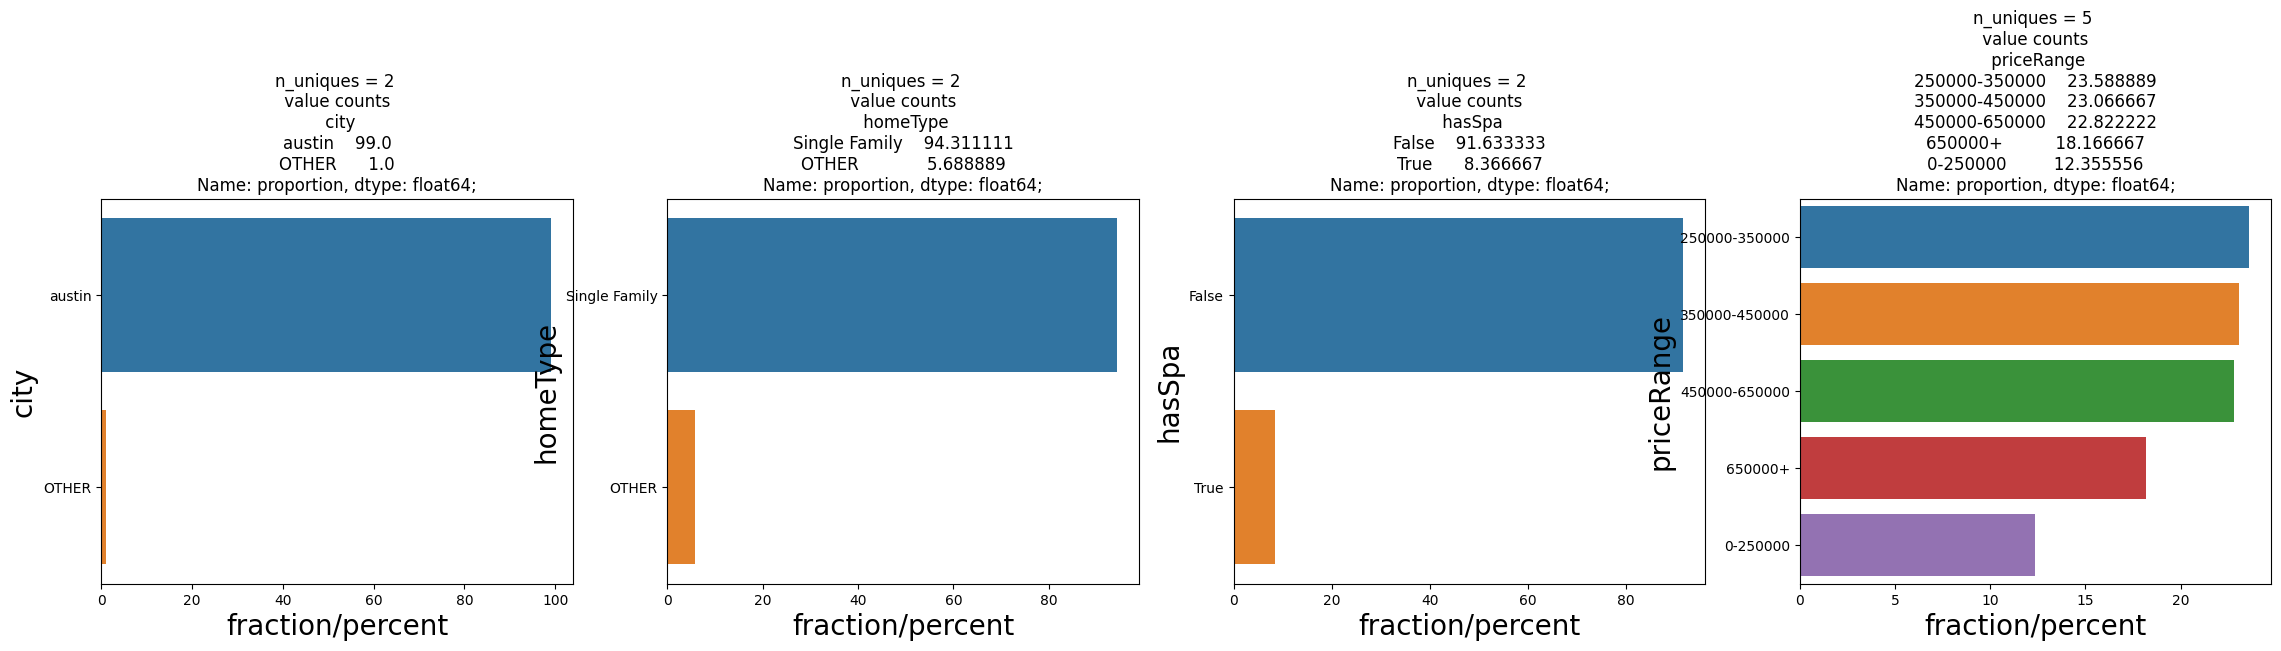

In [59]:
UVA_category(df_train, categorical_without_description)

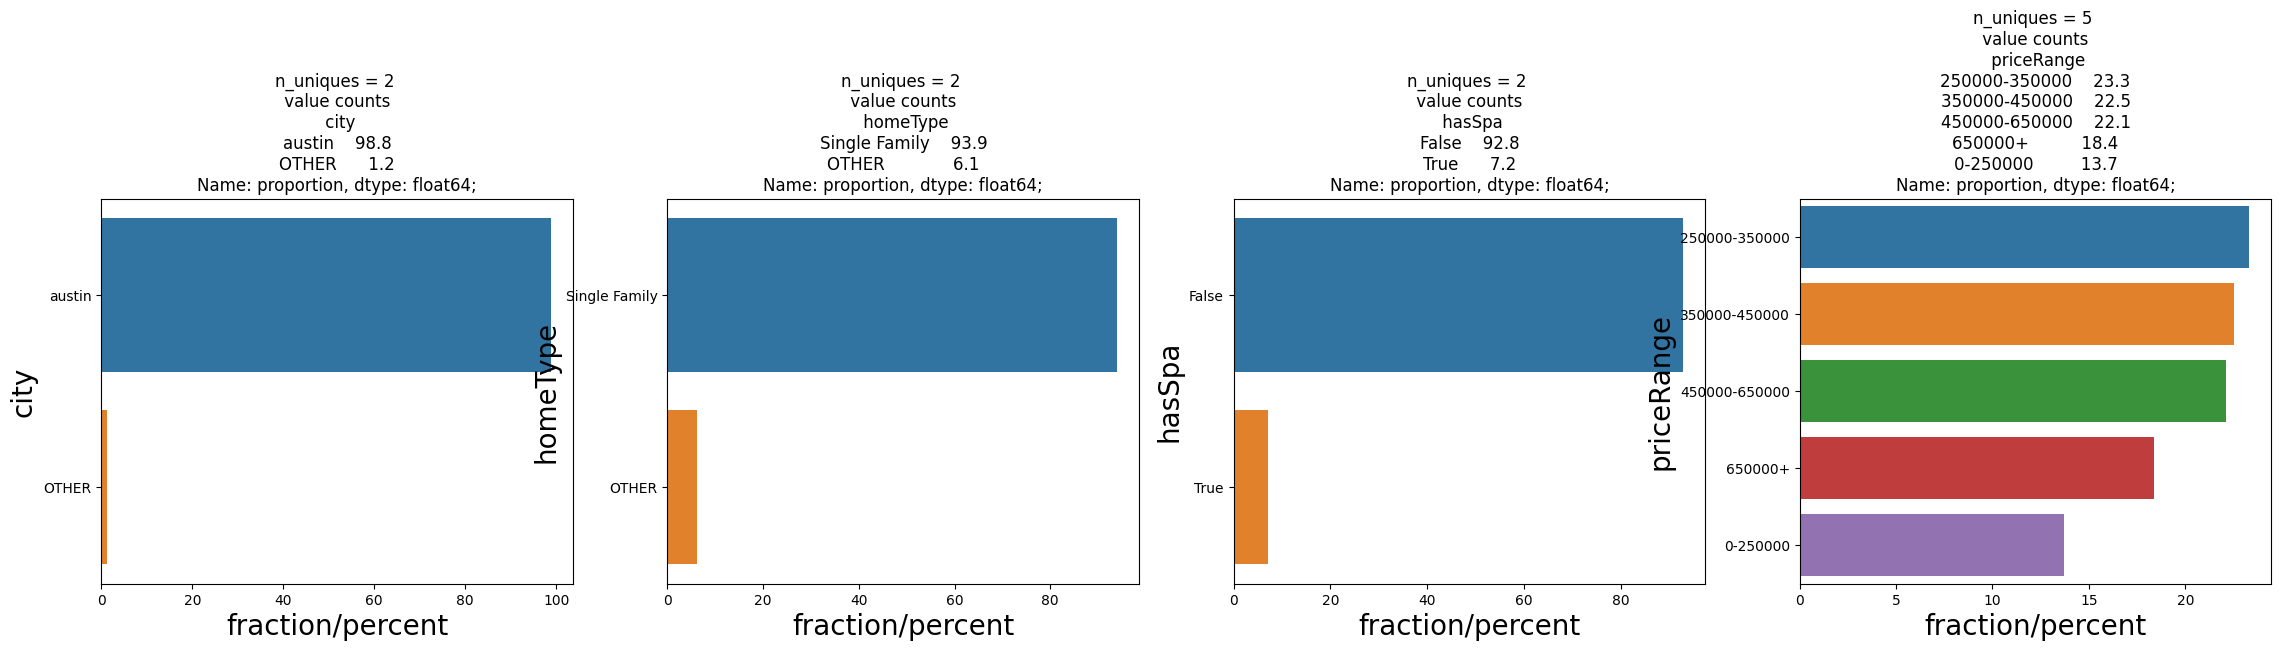

In [60]:
UVA_category(df_test, categorical_without_description)

In [61]:
CATEGORICAL_FEATURES.remove('priceRange')

In [62]:
with open('data/CATEGORICAL_FEATURES', 'wb') as fp4:
    pickle.dump(CATEGORICAL_FEATURES, fp4)

## Univariate Analysis: Numerical Variables

In [63]:
# Listing the Numerical and Categorical datatypes
NUMERICAL_FEATURES = list(df_train.select_dtypes(include=['int64','float64','Int64']).columns)

In [64]:
df_train[NUMERICAL_FEATURES].isnull().sum().sum()

0

In [65]:
NUMERICAL_FEATURES

['latitude',
 'longitude',
 'garageSpaces',
 'yearBuilt',
 'numOfPatioAndPorchFeatures',
 'lotSizeSqFt',
 'avgSchoolRating',
 'MedianStudentsPerTeacher',
 'numOfBathrooms',
 'numOfBedrooms',
 'homeType_count',
 'city_count']

In [66]:
with open('data/NUMERICAL_FEATURES', 'wb') as fp6:
    pickle.dump(NUMERICAL_FEATURES, fp6)

In [67]:
class MedianImputer:
    def __init__(self, variables=None):
        self.variables = variables
        self.median_dict = {}

    def fit(self, df):
        for col in self.variables:
            # Calculate and store the median for each variable
            self.median_dict[col] = df[col].median()
        return self

    def transform(self, df):
        df = df.copy()
        for col in self.variables:
            # Fill missing values with the stored median for each variable
            df[col].fillna(self.median_dict[col], inplace=True)
        return df

In [68]:
df_train[NUMERICAL_FEATURES] = (
    MedianImputer(variables=NUMERICAL_FEATURES)
    .fit(df_train[NUMERICAL_FEATURES])
    .transform(df_train[NUMERICAL_FEATURES])
)
df_test[NUMERICAL_FEATURES] = (
    MedianImputer(variables=NUMERICAL_FEATURES)
    .fit(df_test[NUMERICAL_FEATURES])
    .transform(df_test[NUMERICAL_FEATURES])
)

In [69]:
# custom function for easy and efficient analysis of numerical univariate


def UVA_numeric(data, var_group):
    """
    Univariate_Analysis_numeric
    takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

    Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
    """

    size = len(var_group)
    plt.figure(figsize=(7 * size, 3), dpi=100)

    # looping for each variable
    for j, i in enumerate(var_group):

        # calculating descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max() - data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # calculating points of standard deviation
        points = mean - st_dev, mean + st_dev

        # Plotting the variable with every information
        plt.subplot(1, size, j + 1)
        sns.kdeplot(x=data[i], shade=True)
        sns.lineplot(x=points, y=[0, 0], color="black", label="std_dev")
        sns.scatterplot(x=[mini, maxi], y=[0, 0], color="orange", label="min/max")
        sns.scatterplot(x=[mean], y=[0], color="red", label="mean")
        sns.scatterplot(x=[median], y=[0], color="blue", label="median")
        plt.xlabel("{}".format(i), fontsize=20)
        plt.ylabel("density")
        plt.title(
            "within 1 std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}".format(
                (round(points[0], 2), round(points[1], 2)),
                round(kurt, 2),
                round(skew, 2),
                (round(mini, 2), round(maxi, 2), round(ran, 2)),
                round(mean, 2),
                round(median, 2),
            )
        )


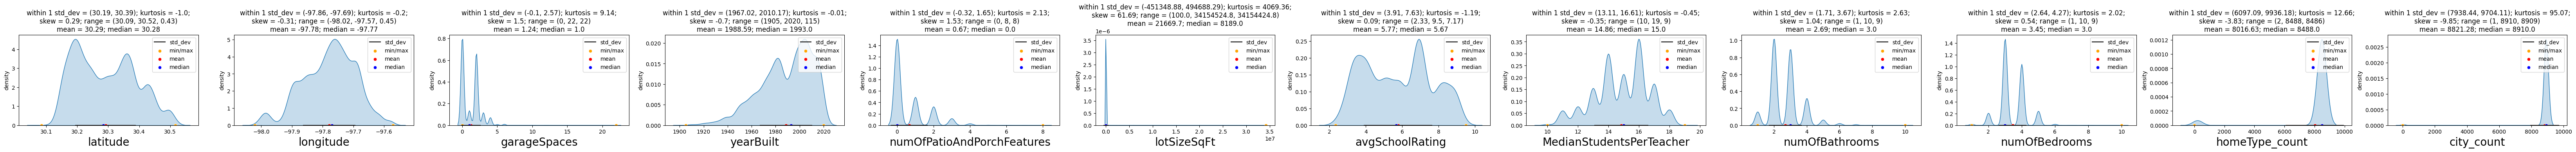

In [70]:
UVA_numeric(df_train,NUMERICAL_FEATURES)

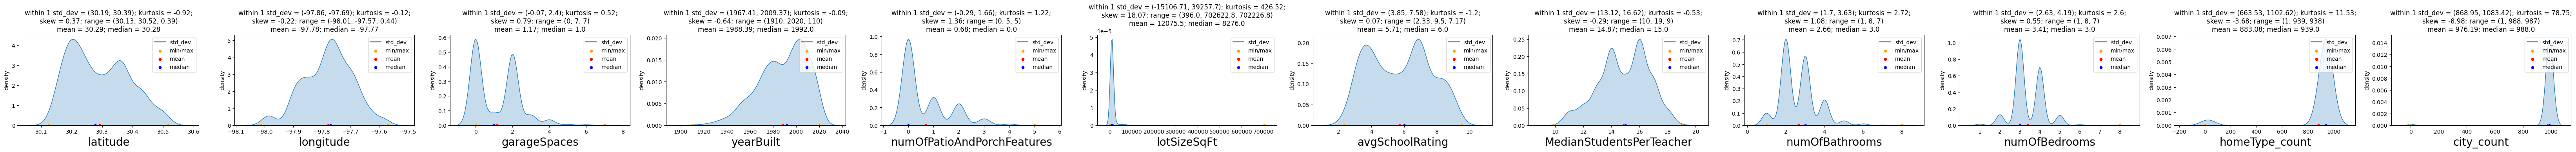

In [71]:
UVA_numeric(df_test,NUMERICAL_FEATURES)

### Univariate Analysis: Outliers

In [72]:
# custom function for easy outlier analysis


def UVA_outlier(data, var_group, include_outlier=True):
    """
    Univariate_Analysis_outlier:
    takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
    Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

    data : dataframe from which to plot from\n
    var_group : {list} type Group of Continuous variables\n
    include_outlier : {bool} whether to include outliers or not, default = True\n
    """

    size = len(var_group)
    plt.figure(figsize=(7 * size, 4), dpi=100)

    # looping for each variable
    for j, i in enumerate(var_group):

        # calculating descriptives of variable
        quant25 = data[i].quantile(0.25)
        quant75 = data[i].quantile(0.75)
        IQR = quant75 - quant25
        med = data[i].median()
        whis_low = med - (1.5 * IQR)
        whis_high = med + (1.5 * IQR)

        # Calculating Number of Outliers
        outlier_high = len(data[i][data[i] > whis_high])
        outlier_low = len(data[i][data[i] < whis_low])

        if include_outlier == True:
            print(include_outlier)
            # Plotting the variable with every information
            plt.subplot(1, size, j + 1)
            sns.boxplot(data[i], orient="v")
            plt.ylabel("{}".format(i))
            plt.title(
                "With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n".format(
                    round(IQR, 2),
                    round(med, 2),
                    (round(quant25, 2), round(quant75, 2)),
                    (outlier_low, outlier_high),
                )
            )

        else:
            # replacing outliers with max/min whisker
            data2 = data[var_group][:]
            data2[i][data2[i] > whis_high] = whis_high + 1
            data2[i][data2[i] < whis_low] = whis_low - 1

            # plotting without outliers
            plt.subplot(1, size, j + 1)
            sns.boxplot(data2[i], orient="v")
            plt.ylabel("{}".format(i))
            plt.title(
                "Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n".format(
                    round(IQR, 2),
                    round(med, 2),
                    (round(quant25, 2), round(quant75, 2)),
                    (outlier_low, outlier_high),
                )
            )

True
True
True
True
True
True
True
True
True
True
True
True


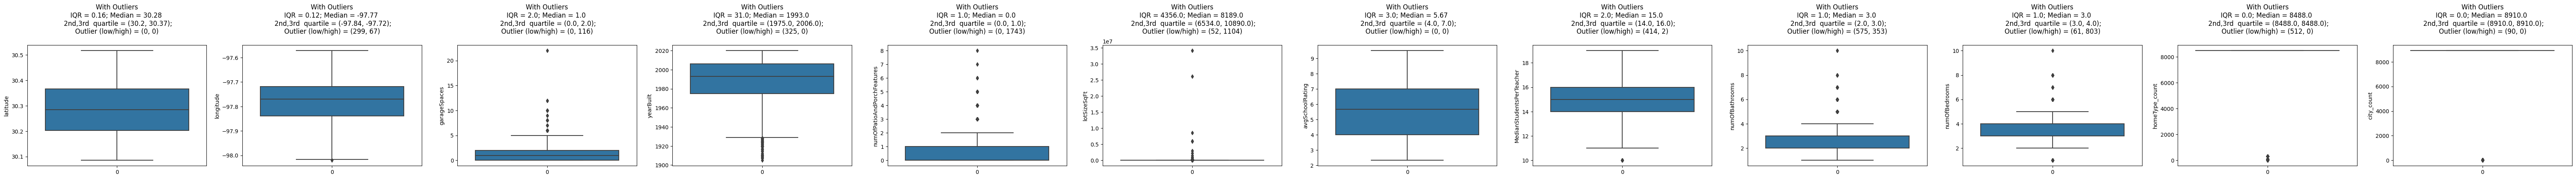

In [73]:
UVA_outlier(df_train,NUMERICAL_FEATURES,)

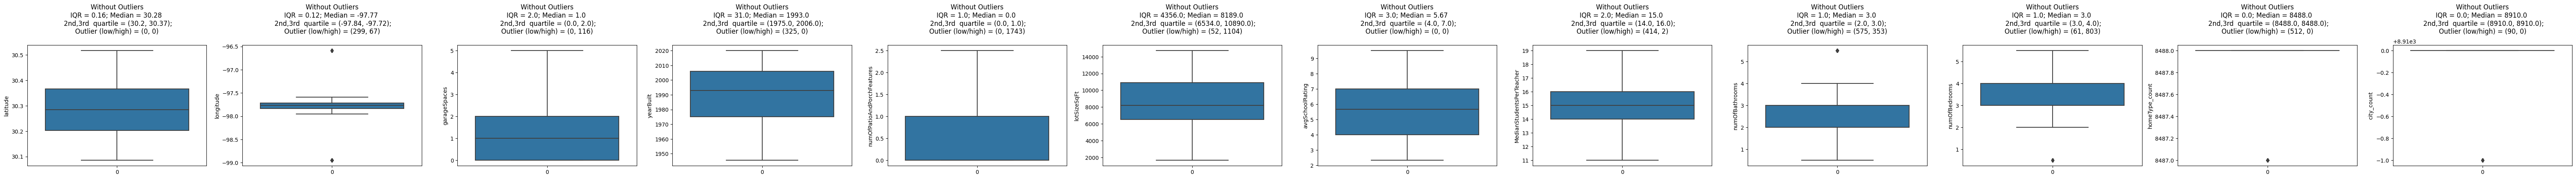

In [74]:
UVA_outlier(df_train,NUMERICAL_FEATURES,False)

In [75]:
from scipy.stats.mstats import winsorize

In [76]:
datasets = [df_train, df_test]

for data in datasets:
    for feature in NUMERICAL_FEATURES:
        data[feature+'_winsor'] = winsorize(data[feature], limits=[0.025, 0.025])

In [77]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,9000.0,30.291226,0.097163,30.085030,30.202113,30.283991,30.366539,3.051732e+01
longitude,9000.0,-97.778541,0.084422,-98.020477,-97.838421,-97.769585,-97.718212,-9.757133e+01
garageSpaces,9000.0,1.236444,1.337852,0.000000,0.000000,1.000000,2.000000,2.200000e+01
yearBuilt,9000.0,1988.590556,21.575392,1905.000000,1975.000000,1993.000000,2006.000000,2.020000e+03
numOfPatioAndPorchFeatures,9000.0,0.665556,0.987494,0.000000,0.000000,0.000000,1.000000,8.000000e+00
lotSizeSqFt,9000.0,21669.704867,473018.587111,100.000000,6534.000000,8189.000000,10890.000000,3.415452e+07
avgSchoolRating,9000.0,5.771954,1.861267,2.333333,4.000000,5.666667,7.000000,9.500000e+00
MedianStudentsPerTeacher,9000.0,14.856667,1.748465,10.000000,14.000000,15.000000,16.000000,1.900000e+01
numOfBathrooms,9000.0,2.687889,0.982358,1.000000,2.000000,3.000000,3.000000,1.000000e+01
numOfBedrooms,9000.0,3.453222,0.816835,1.000000,3.000000,3.000000,4.000000,1.000000e+01


In [78]:
NUMERICAL_FEATURES_WINSOR = [feature+'_winsor' for feature in NUMERICAL_FEATURES]

with open('data/NUMERICAL_FEATURES_WINSOR', 'wb') as fp7:
    pickle.dump(NUMERICAL_FEATURES_WINSOR, fp7)

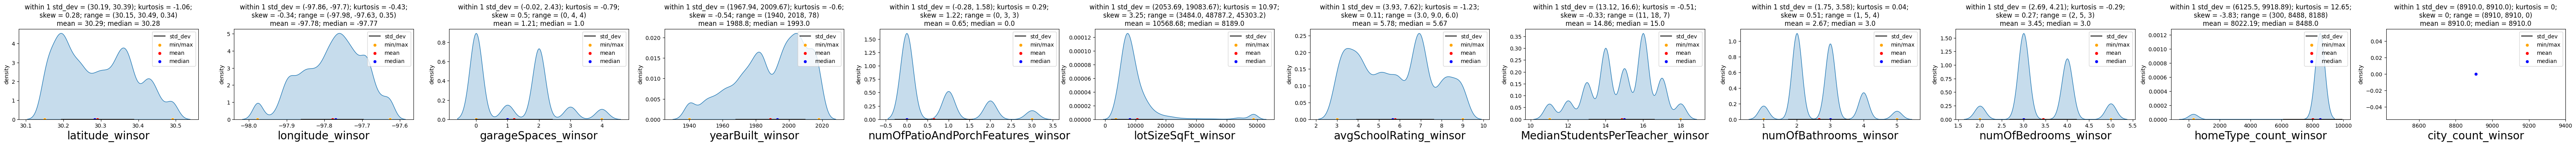

In [79]:
UVA_numeric(df_train,NUMERICAL_FEATURES_WINSOR)

In [80]:
df_train.shape

(9000, 29)

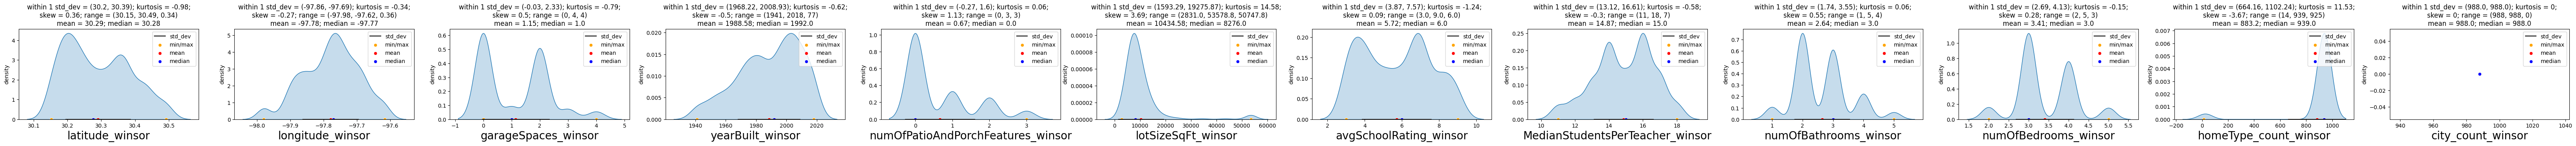

In [81]:
UVA_numeric(df_test,NUMERICAL_FEATURES_WINSOR)

In [82]:
GEOLOCATION_0 = ['latitude', 'longitude']

GEOLOCATION = ['latitude_winsor', 'longitude_winsor']

with open('data/GEOLOCATION_0', 'wb') as fp9:
    pickle.dump(GEOLOCATION_0, fp9)
    
with open('data/GEOLOCATION', 'wb') as fp8:
    pickle.dump(GEOLOCATION, fp8)

In [83]:
### Binned Coordinates ###
df_train['latitude_round3'] = np.round(df_train['latitude_winsor'],3)
df_train['longitude_round3'] = np.round(df_train['longitude_winsor'],3)

### Binned Coordinates ###
df_test['latitude_round3'] = np.round(df_test['latitude_winsor'],3)
df_test['longitude_round3'] = np.round(df_test['longitude_winsor'],3)

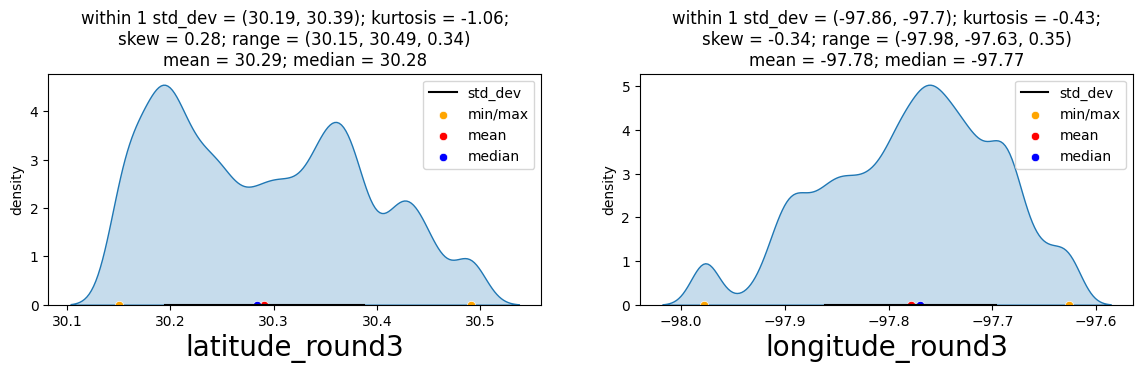

In [84]:
UVA_numeric(df_train,['latitude_round3', 'longitude_round3'])

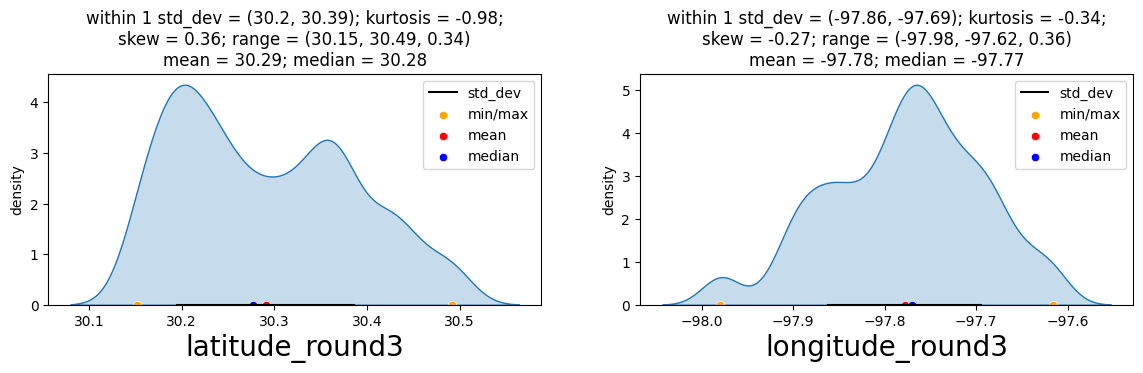

In [85]:
UVA_numeric(df_test,['latitude_round3', 'longitude_round3'])

We then consider the following dataset:

In [86]:
NUMERICAL_FEATURES_WINSOR

['latitude_winsor',
 'longitude_winsor',
 'garageSpaces_winsor',
 'yearBuilt_winsor',
 'numOfPatioAndPorchFeatures_winsor',
 'lotSizeSqFt_winsor',
 'avgSchoolRating_winsor',
 'MedianStudentsPerTeacher_winsor',
 'numOfBathrooms_winsor',
 'numOfBedrooms_winsor',
 'homeType_count_winsor',
 'city_count_winsor']

In [87]:
df_train_numerical = df_train[['latitude_round3', 'longitude_round3'] + NUMERICAL_FEATURES_WINSOR].drop(['latitude_winsor', 'longitude_winsor',
                                                                                             'homeType_count_winsor', 'city_count_winsor'], axis=1)

df_test_numerical = df_test[['latitude_round3', 'longitude_round3'] + NUMERICAL_FEATURES_WINSOR].drop(['latitude_winsor', 'longitude_winsor',
                                                                                             'homeType_count_winsor', 'city_count_winsor'], axis=1)

In [88]:
df_train_numerical.sample()

,latitude_round3,longitude_round3,garageSpaces_winsor,yearBuilt_winsor,numOfPatioAndPorchFeatures_winsor,lotSizeSqFt_winsor,avgSchoolRating_winsor,MedianStudentsPerTeacher_winsor,numOfBathrooms_winsor,numOfBedrooms_winsor
548,30.196,-97.826,2,1986,0,6969.0,4.0,13,2,3


In [89]:
numerical = list(df_train_numerical.select_dtypes(include=['int64','float64','Int64']).columns)

In [90]:
NUMERICAL_FEATURE2 = numerical

with open('data/NUMERICAL_FEATURE2', 'wb') as fp9:
    pickle.dump(NUMERICAL_FEATURE2, fp9)

In [91]:
df_train[['longitude_round3', 'latitude_round3']].describe().T

,count,mean,std,min,25%,50%,75%,max
longitude_round3,9000.0,-97.778772,0.082451,-97.978,-97.83825,-97.770,-97.718,-97.626
latitude_round3,9000.0,30.291178,0.096392,30.150,30.20200,30.284,30.367,30.491


<center><h1>💻💻 Preprocessing Text 💻 💻</h1></center>

In [92]:
DESCRIPTION_FEATURE = 'description'

with open('data/DESCRIPTION_FEATURE', 'wb') as fp10:
    pickle.dump(DESCRIPTION_FEATURE, fp10)

In [93]:
df_train_text = df_train[[DESCRIPTION_FEATURE]]
df_test_text = df_test[[DESCRIPTION_FEATURE]]

In [94]:
df_train_text.shape, df_test_text.shape

((9000, 1), (1000, 1))

In [95]:
df_train_text.sample()

,description
4110,OWNER/AGENT - Don't miss this lovely 3/2 in th...


In [96]:
def get_singular(word):
    singular = wordnet.morphy(word)
    return singular if singular else word

In [97]:
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

In [98]:
def count_words(str):
    return len(str.split())

In [99]:
df_train_text['number_words'] = df_train_text['description'].progress_apply(lambda x: count_words(x))
df_test_text['number_words'] = df_test_text['description'].progress_apply(lambda x: count_words(x))

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 149486.92it/s]


In [100]:
df_train_text['number_words'].describe()

count    9000.000000
mean       70.721222
std        48.604908
min         0.000000
25%        29.000000
50%        71.000000
75%        82.000000
max       683.000000
Name: number_words, dtype: float64

In [101]:
df_test_text['number_words'].describe()

count    1000.00000
mean       67.14600
std        39.26485
min         1.00000
25%        29.00000
50%        70.00000
75%        82.00000
max       528.00000
Name: number_words, dtype: float64

In [102]:
def clean_text(text, blacklist):
    if not isinstance(text, str):
        return text  # Avoid processing NaN or None values
    text = text.lower()
    text = remove_unwanted_patterns(text)
    words = text.split()
    words = [lemmatize_and_singularize(word) for word in words]
    words = [word for word in words if word not in blacklist]
    return " ".join(words).strip()

def remove_unwanted_patterns(text):
    patterns_to_remove = [
        r"[^a-z\s]",  # Remove non-alphabetic characters
        r"@[A-Za-z0-9]+",  # Remove mentions
        r"http\S+",  # Remove URLs
        r"#\S+",  # Remove hashtags
        r"[\W_]+",  # Remove non-word characters
        r"\s+",  # Replace multiple spaces with single space
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, " ", text)
    return text

def lemmatize_and_singularize(word):
    singular = wordnet.morphy(word)  # Get the singular form of the word
    return lemmatizer.lemmatize(singular if singular else word)

In [103]:
# Define a blacklist
BLACK_LIST = {'and', 'is', 'a', 'in', 'an', 'the', 'these', 'thi', 'this', '&', 'ft', 'st', 'pm', 'sq', 'home', 'room', 
             'bedroom', 'kitchen', 'floor', 'master', 'bathroom', 'bath', 'bed', 'austin', 'tx', 'that',
             'for','of', 'on', 'to', 'with', 'it', 'or', 'you', 'all', 'was', 'wa', 'ha', 'has', 'be'}

with open('data/BLACK_LIST', 'wb') as fp11:
    pickle.dump(BLACK_LIST, fp11)

In [104]:
df_train_text['clean_text']=df_train_text['description'].progress_apply(lambda x: clean_text(x, blacklist=BLACK_LIST))
df_test_text['clean_text']=df_test_text['description'].progress_apply(lambda x: clean_text(x, blacklist=BLACK_LIST))

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1876.34it/s]


In [105]:
df_train_text['number_words_clean'] = df_train_text['clean_text'].progress_apply(lambda x: count_words(x))
df_test_text['number_words_clean'] = df_test_text['clean_text'].progress_apply(lambda x: count_words(x))

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 223541.22it/s]


In [106]:
df_train_text.sample()

,description,number_words,clean_text,number_words_clean
4387,"Cute and cozy townhome,come to everything you ...",72,cute cozy townhome come everything want s quie...,47


In [107]:
df_train_text.describe().T

,count,mean,std,min,25%,50%,75%,max
number_words,9000.0,70.721222,48.604908,0.0,29.0,71.0,82.0,683.0
number_words_clean,9000.0,46.491444,35.660412,0.0,17.0,49.0,59.0,449.0


In [108]:
df_test_text.head(1)

,description,number_words,clean_text,number_words_clean
0,Simple comtemporary home with contemporary int...,6,simple comtemporary contemporary interior,4


In [109]:
df_train['priceRange'].value_counts()

priceRange
250000-350000    2123
350000-450000    2076
450000-650000    2054
650000+          1635
0-250000         1112
Name: count, dtype: int64

In [110]:
df_test_text.describe().T

,count,mean,std,min,25%,50%,75%,max
number_words,1000.0,67.146,39.264850,1.0,29.0,70.0,82.0,528.0
number_words_clean,1000.0,44.078,30.139315,1.0,13.0,49.0,59.0,360.0


In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
vectorizer = TfidfVectorizer(max_features=20)  # Consider top 1000 terms

# Fit and transform the text data
tfidf_train_features = vectorizer.fit_transform(df_train_text['clean_text'])
# Fit and transform the text data
tfidf_test_features = vectorizer.fit_transform(df_test_text['clean_text'])

In [112]:
# Create a DataFrame for better readability
feature_names = vectorizer.get_feature_names_out()
df_train[feature_names] = pd.DataFrame(tfidf_train_features.toarray(), columns=feature_names)

# Create a DataFrame for better readability
feature_names = vectorizer.get_feature_names_out()
df_test[feature_names] = pd.DataFrame(tfidf_test_features.toarray(), columns=feature_names)

In [113]:
df_train[feature_names]

,appliance,area,back,backyard,build,ceiling,contain,family,feature,from,great,include,large,living,lot,new,open,single,update,walk
0,0.000000,0.000000,0.000000,0.000000,0.406657,0.000000,0.000000,0.00000,0.000000,0.399231,0.000000,0.333042,0.340036,0.380590,0.000000,0.000000,0.368504,0.000000,0.409949,0.000000
1,0.000000,0.000000,0.000000,0.325096,0.000000,0.806493,0.324306,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372434,0.000000,0.000000,0.000000
2,0.460560,0.387663,0.000000,0.101562,0.128397,0.000000,0.405259,0.00000,0.131134,0.000000,0.000000,0.315461,0.536810,0.120166,0.000000,0.104872,0.000000,0.000000,0.000000,0.127482
3,0.000000,0.423340,0.391272,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.412957,0.431349,0.000000,0.000000,0.000000,0.000000,0.343570,0.000000,0.439379,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.000000,0.000000,0.000000,0.436457,0.000000,0.000000,0.000000,0.00000,0.000000,0.541702,0.000000,0.000000,0.000000,0.516409,0.499386,0.000000,0.000000,0.000000,0.000000,0.000000
8996,0.000000,0.000000,0.000000,0.325096,0.000000,0.806493,0.324306,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372434,0.000000,0.000000,0.000000
8997,0.000000,0.298939,0.276294,0.234952,0.297032,0.000000,0.234381,0.00000,0.303364,0.291607,0.000000,0.243261,0.000000,0.277992,0.000000,0.485219,0.000000,0.000000,0.000000,0.294915
8998,0.453704,0.000000,0.235309,0.000000,0.252971,0.000000,0.000000,0.25071,0.000000,0.000000,0.518823,0.000000,0.423055,0.236755,0.000000,0.206621,0.000000,0.000000,0.255018,0.000000


In [114]:
# note that all the columns in both dataframes are the same

no_common1 = [element for element in list(df_train[feature_names].columns) if element not in list(df_test[feature_names].columns)]
no_common2 = [element for element in list(df_test[feature_names].columns) if element not in list(df_train[feature_names].columns)]

In [115]:
no_common1, no_common2

([], [])

In [116]:
TO_REMOVE = ["appliance", "space"]

with open('data/TO_REMOVE', 'wb') as fp11:
    pickle.dump(TO_REMOVE, fp11)

In [117]:
numerical_text = list(df_train[feature_names].columns)

## Feature tools - Creation of new features

The new dataset is now

In [118]:
df_train2 = pd.concat([df_train_numerical, df_train[feature_names]], axis=1)
df_test2 = pd.concat([df_test_numerical, df_test[feature_names]], axis=1)

In [119]:
df_test2.sample()

,latitude_round3,longitude_round3,garageSpaces_winsor,yearBuilt_winsor,numOfPatioAndPorchFeatures_winsor,lotSizeSqFt_winsor,avgSchoolRating_winsor,MedianStudentsPerTeacher_winsor,numOfBathrooms_winsor,numOfBedrooms_winsor,appliance,area,back,backyard,build,ceiling,contain,family,feature,from,great,include,large,living,lot,new,open,single,update,walk
669,30.308,-97.655,0,1977,0,10193.0,3.666667,14,2,3,0.0,0.0,0.0,0.301065,0.0,0.0,0.0,0.257919,0.0,0.0,0.0,0.0,0.555808,0.0,0.0,0.0,0.0,0.292114,0.0,0.669765


In [120]:
df_train2.shape, df_test2.shape

((9000, 30), (1000, 30))

In [121]:
import featuretools as ft

In [122]:
es_train = ft.EntitySet(id = 'predictor')
es_train

Entityset: predictor
  DataFrames:
  Relationships:
    No relationships

In [123]:
es_train = ft.EntitySet(id='data_1')
es_train = es_train.add_dataframe(dataframe_name='data_1', 
                      dataframe=df_train, 
                      index='index', 
                      make_index=False)

In [124]:
es_test = ft.EntitySet(id='data_1')
es_test = es_test.add_dataframe(dataframe_name='data_1', 
                      dataframe=df_test, 
                      index='index', 
                      make_index=False)

In [125]:
# Run deep feature synthesis with transformation primitives
feature_matrix_train, feature_defs_train = ft.dfs(entityset=es_train, target_dataframe_name='data_1', max_depth=1,
                                      trans_primitives=['add_numeric', 'multiply_numeric'])

In [126]:
# Run deep feature synthesis with transformation primitives
feature_matrix_test, feature_defs_test= ft.dfs(entityset=es_test, target_dataframe_name='data_1', max_depth=1,
                                      trans_primitives=['add_numeric', 'multiply_numeric'])

In [127]:
feature_matrix_train.shape, feature_matrix_test.shape

((9000, 2120), (1000, 2120))

In [128]:
# note that all the columns in both dataframes are the same

no_common1 = [element for element in list(feature_matrix_train.columns) if element not in list(feature_matrix_test.columns)]
no_common2 = [element for element in list(feature_matrix_test.columns) if element not in list(feature_matrix_train.columns)]

In [129]:
no_common1, no_common2

([], [])

In [130]:
numerical_tools = list(feature_matrix_train.select_dtypes(include=['int64','float64','Int64']).columns)

In [131]:
len(numerical_tools)

2116

In [132]:
feature_matrix_train[numerical_tools] = np.log(abs(feature_matrix_train[numerical_tools]) + 1)
feature_matrix_test[numerical_tools] = np.log(abs(feature_matrix_test[numerical_tools]) + 1)

In [133]:
std_train = StandardScaler()
scaled_train = std_train.fit_transform(feature_matrix_train[numerical_tools])
scaled_train = pd.DataFrame(scaled_train, columns=numerical_tools)

std_test = StandardScaler()
scaled_test = std_train.fit_transform(feature_matrix_test[numerical_tools])
scaled_test = pd.DataFrame(scaled_test, columns=numerical_tools)

In [134]:
scaled_test.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,1000.0,-6.527046e-14,1.0005,-1.715664,-0.886442,-0.143873,0.769340,2.342109
longitude,1000.0,3.176481e-13,1.0005,-2.422900,-0.683465,-0.086575,0.717948,2.724750
garageSpaces,1000.0,-8.881784e-18,1.0005,-1.037346,-1.037346,0.148060,0.841477,2.518870
yearBuilt,1000.0,3.821832e-14,1.0005,-3.795978,-0.681125,0.176752,0.803306,1.495947
numOfPatioAndPorchFeatures,1000.0,-1.598721e-17,1.0005,-0.767710,-0.767710,-0.767710,0.622733,2.826532
...,...,...,...,...,...,...,...,...
update * yearBuilt,1000.0,-4.796163e-17,1.0005,-0.497449,-0.497449,-0.497449,-0.497449,2.348721
update * yearBuilt_winsor,1000.0,1.243450e-17,1.0005,-0.497449,-0.497449,-0.497449,-0.497449,2.348675
walk * yearBuilt,1000.0,-2.131628e-17,1.0005,-0.503706,-0.503706,-0.503706,-0.503706,2.339511
walk * yearBuilt_winsor,1000.0,-4.973799e-17,1.0005,-0.503706,-0.503706,-0.503706,-0.503706,2.339492


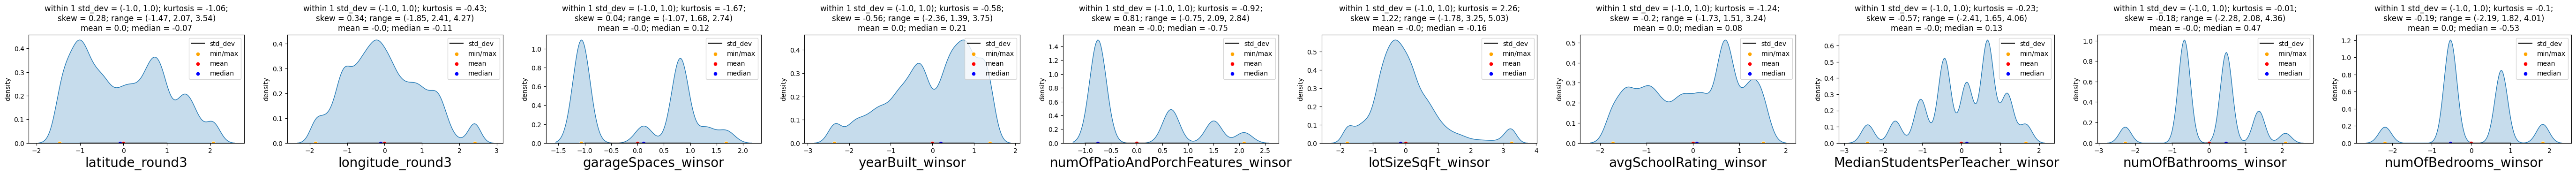

In [135]:
UVA_numeric(scaled_train,numerical)

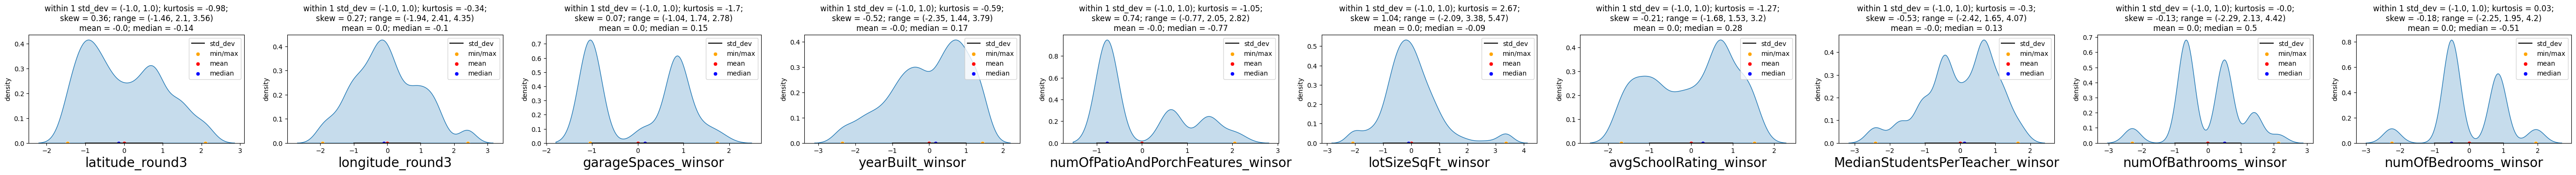

In [136]:
UVA_numeric(scaled_test,numerical)

In [137]:
from sklearn.preprocessing import MinMaxScaler

In [138]:
min_max_train = MinMaxScaler()
scaled_min_max_train = min_max_train.fit_transform(scaled_train[numerical_tools])
scaled_min_max_train = pd.DataFrame(scaled_min_max_train, columns=numerical_tools)

In [139]:
min_max_test = MinMaxScaler()
scaled_min_max_test = min_max_test.fit_transform(scaled_test[numerical_tools])
scaled_min_max_test = pd.DataFrame(scaled_min_max_test, columns=numerical_tools)

In [140]:
scaled_min_max_train.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,9000.0,0.478358,0.224730,0.0,0.272210,0.461962,0.652768,1.0
longitude,9000.0,0.461822,0.187971,0.0,0.327518,0.441957,0.595205,1.0
garageSpaces,9000.0,0.201017,0.190042,0.0,0.000000,0.221065,0.350379,1.0
yearBuilt,9000.0,0.731629,0.185827,0.0,0.615642,0.770426,0.881347,1.0
numOfPatioAndPorchFeatures,9000.0,0.169223,0.226162,0.0,0.000000,0.000000,0.315465,1.0
...,...,...,...,...,...,...,...,...
update * yearBuilt,9000.0,0.182335,0.357158,0.0,0.000000,0.000000,0.000000,1.0
update * yearBuilt_winsor,9000.0,0.182339,0.357167,0.0,0.000000,0.000000,0.000000,1.0
walk * yearBuilt,9000.0,0.186347,0.356139,0.0,0.000000,0.000000,0.000000,1.0
walk * yearBuilt_winsor,9000.0,0.186350,0.356144,0.0,0.000000,0.000000,0.000000,1.0


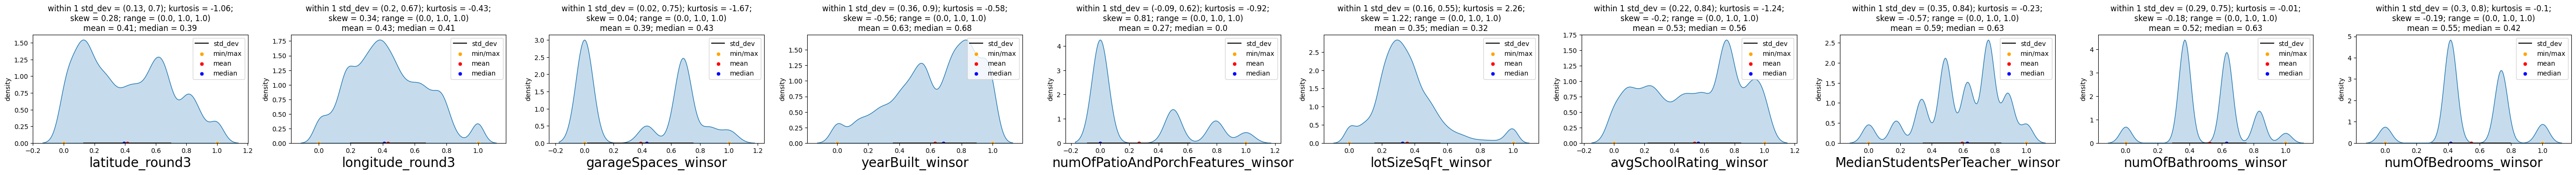

In [141]:
UVA_numeric(scaled_min_max_train,numerical)

### High correlation filtering

In [142]:
# creating the correlation matrix
corr_matrix = scaled_min_max_test[numerical_tools].corr().abs()

In [143]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

In [144]:
s = corr_matrix.unstack()
so = s.sort_values(kind="quicksort",ascending = False)
so = pd.DataFrame(so, columns=['Pearson Correlation'])

In [145]:
so[so['Pearson Correlation']<1].head()

,,Pearson Correlation
longitude_winsor + lotSizeSqFt_winsor,longitude_round3 + lotSizeSqFt_winsor,1.0
longitude_round3 + lotSizeSqFt_winsor,longitude_winsor + lotSizeSqFt_winsor,1.0
latitude_round3 + lotSizeSqFt_winsor,latitude_winsor + lotSizeSqFt_winsor,1.0
latitude_winsor + lotSizeSqFt_winsor,latitude_round3 + lotSizeSqFt_winsor,1.0
longitude_round3 + lotSizeSqFt,longitude_winsor + lotSizeSqFt,1.0


For higher correlation filter conditions we have that the 'MedianStudentsPerTeacher' feature it will be not consider in the sequel:

In [146]:
# fining index of variables with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [147]:
len(to_drop)

1857

In [148]:
numerical_consider = [x for x in numerical_tools if x not in to_drop and x not in numerical and x not in numerical_text]

In [149]:
len(numerical_consider)

240

### Low variance filter

In [150]:
from sklearn.preprocessing import normalize

In [151]:
normalize = normalize(feature_matrix_train[numerical_consider])

In [152]:
data_scaled = pd.DataFrame(normalize)

In [153]:
# storing the variance and name of variables
variance = data_scaled.var()
columns = feature_matrix_train[numerical_consider].columns

In [154]:
# Creating a DataFrame from the variances
variance_df = pd.DataFrame(variance, columns=['Variance'])
variance_df['Column'] = columns
variance_df = variance_df.reset_index(drop=True)

In [155]:
variance_df.sort_values(by='Variance', ascending=False).head()

,Variance,Column
9,0.001883,homeType_count
2,0.000818,garageSpaces
10,0.000799,city_count
5,0.000573,lotSizeSqFt
4,0.000570,numOfPatioAndPorchFeatures


In [156]:
# saving the names of variables having variance more than a threshold value
variable = []
for i in range(0,len(variance)):
    if variance[i] >= variance.mean():  
        variable.append(columns[i])

In [157]:
len(variable)

66

## Final Datasets

In [158]:
final_train = pd.concat([feature_matrix_train[numerical+numerical_text+variable], df_train[['city','homeType','hasSpa','priceRange']]], axis=1)
final_test = pd.concat([feature_matrix_test[numerical+numerical_text+variable], df_test[['city','homeType','hasSpa','priceRange']]], axis=1)

In [159]:
df_train.shape, final_train.shape, df_test.shape, final_test.shape

((9000, 52), (9000, 100), (1000, 52), (1000, 100))

#### Categorical to numerical features:

In [160]:
datasets = [final_train, final_train]

for data in datasets:
    for column in ['city', 'homeType', 'hasSpa']:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

In [161]:
final_train['homeType'].value_counts(normalize=True)

homeType
1    0.943111
0    0.056889
Name: proportion, dtype: float64

In [162]:
final_train['hasSpa'].value_counts(normalize=True)*100

hasSpa
0    91.633333
1     8.366667
Name: proportion, dtype: float64

In [163]:
set(list(final_train.dtypes))

{CategoricalDtype(categories=['0-250000', '250000-350000', '350000-450000', '450000-650000', '650000+'], ordered=False),
 dtype('float64'),
 dtype('int64')}

In [164]:
final_columns = list(final_train.columns)

In [165]:
datasets = [final_train, final_train]

In [166]:
import pickle

with open('data/datasets', 'wb') as fp:
    pickle.dump(final_columns, fp)

In [167]:
with open ('data/datasets', 'rb') as fp:
    itemlist = pickle.load(fp)

In [168]:
CONVERSION_DICT2 = {
    "city": float,
    "homeType": float,
    "hasSpa": float,
}

TO_CONVERT2 = list(CONVERSION_DICT2)

In [169]:
with open('data/CONVERSION_DICT2', 'wb') as fp1:
    pickle.dump(CONVERSION_DICT2, fp1)

with open('data/TO_CONVERT2', 'wb') as fp2:
    pickle.dump(TO_CONVERT2, fp2)